In [1]:
print("hello")

hello


In [3]:
import os
import kagglehub
import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
dataset_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
image_dir = os.path.join(dataset_path, "HAM10000_images_part_1")
csv_path = os.path.join(dataset_path, "HAM10000_metadata.csv")


Resuming download from 788529152 bytes (4794385359 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/kmader/skin-cancer-mnist-ham10000?dataset_version_number=2 (788529152/5582914511) bytes left.


100%|█████████████████████████████████████████████████████████████████████████████| 5.20G/5.20G [20:30<00:00, 3.90MB/s]


Extracting files...


In [7]:
df = pd.read_csv(csv_path)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
df = df[df['image_path'].apply(os.path.exists)]  # ensure image exists

In [9]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])

class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(self.df.iloc[idx]['image_path']).convert("RGB")
        label = self.df.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [13]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = SkinCancerDataset(train_df, transform=transform)
test_dataset = SkinCancerDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [15]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(num_classes=len(le.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10 - Loss: 0.9333
Epoch 2/10 - Loss: 0.8212
Epoch 3/10 - Loss: 0.7778
Epoch 4/10 - Loss: 0.7272
Epoch 5/10 - Loss: 0.6816
Epoch 6/10 - Loss: 0.6283
Epoch 7/10 - Loss: 0.6156
Epoch 8/10 - Loss: 0.5504
Epoch 9/10 - Loss: 0.5289
Epoch 10/10 - Loss: 0.4861


In [21]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=le.classes_))


Classification Report:
               precision    recall  f1-score   support

       akiec       0.38      0.14      0.20        37
         bcc       0.38      0.58      0.46        53
         bkl       0.60      0.48      0.53       113
          df       0.00      0.00      0.00        11
         mel       0.46      0.40      0.43        87
          nv       0.87      0.91      0.89       686
        vasc       0.50      0.62      0.55        13

    accuracy                           0.76      1000
   macro avg       0.46      0.45      0.44      1000
weighted avg       0.74      0.76      0.75      1000



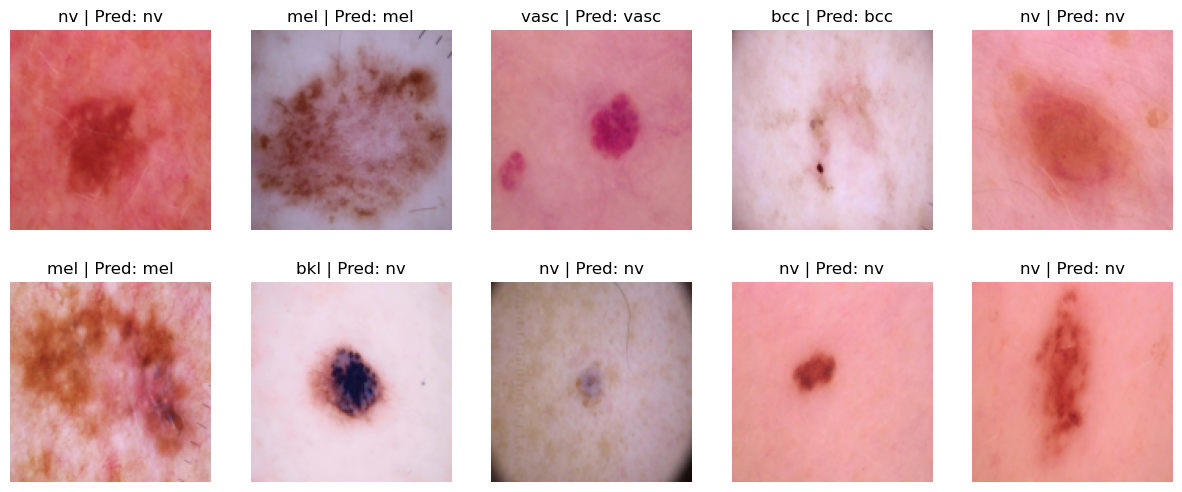

In [23]:
def show_images(dataset, preds=None):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        img, label = dataset[i]
        img = img.permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
        axs[i//5][i%5].imshow(img)
        title = le.inverse_transform([label])[0]
        if preds is not None:
            title += f" | Pred: {le.inverse_transform([preds[i]])[0]}"
        axs[i//5][i%5].set_title(title)
        axs[i//5][i%5].axis('off')
    plt.show()

show_images(test_dataset, all_preds[:10])